# Learning LSTM Autoencoder and LSTM Network on a simple Multivariate Timeseries Toy example

In [1]:
# lstm autoencoder to recreate a timeseries
import pandas as pd
import numpy as np
import ta
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Input
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist 
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering, KMeans
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [20, 10]

Using TensorFlow backend.


In [2]:
'''
A UDF to convert input data into 3-D
array as required for LSTM network.
'''

def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
        output_y.append(y[i+lookback+1])
    return output_X, output_y

In [3]:
csv_path = '../data/btc_1h.csv'
df = pd.read_csv(csv_path, sep=',')
# df = df.drop(columns=['quote_asset_volume', 'number_of_trades',
#                       'buy_base_asset_volume', 'buy_quote_asset_volume', 'open_time', 'close_time', 'ignore'], axis=1)
# df = df.drop(columns=['Adj Close', 'Date'], axis=1)
df = ta.utils.dropna(df)
train_data = df.copy()

data = ta.add_all_ta_features(
    train_data, open='open', high='high', low='low',
    close='close', volume='volume', fillna=True
)

raw_price = data.close.astype('float64').values
data = data.drop(columns=['open', 'high', 'low', 'close', 'volume'], axis=1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data)
timeseries = scaler.transform(data)
timesteps = timeseries.shape[0]
n_features = timeseries.shape[1]
timeseries.shape


c:\users\thinh\miniconda3\envs\p36\lib\site-packages\ta\trend.py:608: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
c:\users\thinh\miniconda3\envs\p36\lib\site-packages\ta\trend.py:612: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


(24181, 72)

In [4]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# pca.fit(timeseries)
# print(pca.explained_variance_ratio_)
# timeseries_pca = pca.transform(timeseries)

In [5]:
timesteps = 10
X, y = temporalize(X=timeseries, y=np.zeros(len(timeseries)), lookback = timesteps)

n_features = timeseries.shape[1]
X = np.array(X)
X = X.reshape(X.shape[0], timesteps, n_features)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)
X_train.shape

(16193, 10, 72)

## LSTM Autoencoder

In [6]:
# define model
inputs = Input(shape=(timesteps, n_features))

encoded = LSTM(512, activation='relu', return_sequences=True)(inputs)
encoded = LSTM(256, activation='relu', return_sequences=True)(encoded)
encoded = LSTM(128, activation='relu', return_sequences=False)(encoded)
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(256, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(512, activation='relu', return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(n_features))(decoded)

model = Model(inputs, decoded)
model.compile(optimizer='adam', loss='mse')
model.summary()

# model.load_weights("models/best_model_weights.h5")
encoder = Model(inputs, encoded)
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10, 72)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 512)           1198080   
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 256)           787456    
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               197120    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 256)           394240    
_________________________________________________________________
lstm

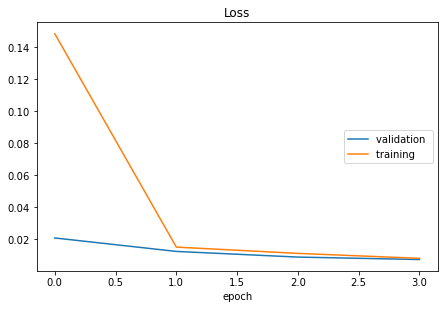

Loss
	validation       	 (min:    0.007, max:    0.021, cur:    0.007)
	training         	 (min:    0.008, max:    0.148, cur:    0.008)


In [ ]:
# fit model
from livelossplot import PlotLossesKeras

es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=50)
mc = ModelCheckpoint('models/best_model_{}.h5'.format(timesteps), monitor='val_loss', mode='min', verbose=0)
model.fit(X_train, X_train,
          epochs=20000,
          batch_size=128,
          verbose=0, 
          validation_data=(X_test, X_test),
          callbacks=[es, mc, PlotLossesKeras()])

In [ ]:
# demonstrate reconstruction
yhat = model.predict(X_test, verbose=0)
# print('---Predicted---')
# print(np.round(yhat,3))
# print('---Actual---')
# print(np.round(X, 3))

In [ ]:
np.round(yhat[0][0],3)

In [ ]:
np.round(X_test[0][0], 3)

In [ ]:
# encoder.save_weights("models/autoencoder_weight.h5")
# encoder.save("models/model.h5")

In [ ]:
# from keras.models import load_model
# saved_model = load_model("models/model.h5")

In [ ]:
# yhat = saved_model.predict(X, verbose=0)
# np.round(yhat[0][0],2)

In [ ]:
X_encoded = encoder.predict(X)
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# plot mixture model clustering

In [ ]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

In [ ]:
import itertools
from scipy import linalg
import matplotlib as mpl
color_iter = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'white', 'violet', 'gold', 'lime']
def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(1, 1, 1)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-9., 5.)
    plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)
    plt.show()

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_encoded)
print(pca.explained_variance_ratio_)
X_encoded_pca = pca.transform(X_encoded)
X_train_encoded_pca = pca.transform(X_train_encoded)
X_test_encoded_pca = pca.transform(X_test_encoded)

In [ ]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,20) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_encoded_pca)     
      
    distortions.append(sum(np.min(cdist(X_encoded_pca, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / X_encoded_pca.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X_encoded_pca, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / X_encoded_pca.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

In [ ]:
clustering = AgglomerativeClustering(n_clusters=2).fit(X_train_encoded_pca)
plt.scatter(X_train_encoded_pca[:, 0], X_train_encoded_pca[:, 1], c=clustering.labels_, s=3, cmap='viridis')

In [ ]:
gmm = GaussianMixture(n_components=2, random_state=42).fit(X_train_encoded_pca)
plot_results(X_test_encoded_pca, gmm.predict(X_test_encoded_pca), gmm.means_, gmm.covariances_, 0, 'Gaussian Mixture')
#Plotting
# fig = plt.figure(1, figsize=(12,10))
# ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
# ax.scatter(X_test_encoded_pca[:, 1], X_test_encoded_pca[:, 0], X_test_encoded_pca[:, 2],
#           c=gmm.predict(X_test_encoded_pca), edgecolor="k", s=50)
# # ax.set_xlabel("Petal width")
# # ax.set_ylabel("Sepal length")
# # ax.set_zlabel("Petal length")
# plt.title("GaussianMixture", fontsize=14)

In [ ]:
dpgmm = BayesianGaussianMixture(n_components=2, random_state=42).fit(X_train_encoded_pca)
plot_results(X_test_encoded_pca, dpgmm.predict(X_test_encoded_pca), dpgmm.means_, dpgmm.covariances_, 1,
             'Bayesian Gaussian Mixture with a Dirichlet process prior')
# fig = plt.figure(1, figsize=(12,10))
# ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
# ax.scatter(X_test_encoded_pca[:, 2], X_test_encoded_pca[:, 0], X_test_encoded_pca[:, 1], c=dpgmm.predict(X_test_encoded_pca), edgecolor="k", s=50)
# plt.title("GaussianMixture", fontsize=14)

In [ ]:
start_index = 0
end_index = 1000
plot_data = raw_price[start_index: end_index]
indexs = [x for x,_ in enumerate(plot_data)]
plt.plot(indexs, plot_data)
area = 20
prev_label = None
colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'white', 'violet', 'gold', 'lime']
labels_proba = dpgmm.predict_proba(X_encoded_pca[start_index:end_index])
for index,item in enumerate(labels_proba):
    cluster = np.argmax(item)
    proba = item[cluster]
    if prev_label != cluster:
        prev_label = cluster
        plt.scatter(index, plot_data[index], s=area, c=colors[cluster], alpha=1)

In [ ]:
with open('raw_price.npy', 'wb') as f:
    np.save(f, raw_price)